In [1]:
!echo $PYTHONPATH
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

%load_ext autoreload
%autoreload 2
# %matplotlib inline
%matplotlib ipympl

/home/dianloo/Desktop/tesi/quilt


In [2]:
from quilt.interface.spiking import set_verbosity
set_verbosity(1)

T = 1000 # simulate for 800 ms
dt = 0.1 # ms
points_per_bin = 10      # bins 1 ms wide
sampling_frequency = 1e3 # 1 kHz sampling frequency
burn_in_millis = 300    # the first part of the record to discard (ms)

In [78]:
from quilt.builder import NeuronCatalogue, SpikingNetwork
catalogue = NeuronCatalogue.from_yaml("tests/basal_ganglia_neurons.yaml")

sn = SpikingNetwork.from_yaml("tests/basal_ganglia_network.yaml", catalogue)

# Magic super clean params: {'poisson_rescale': 1.9739110331634744, 'weight_rescale': 1.7952043585344422}

sn.rescale_populations(1.0)
sn.rescale_connectivity(2.0)
sn.rescale_weights(1.0)
sn.rescale_delays(1.0)

poisson_rescale = 1.97

sn.build()

Output()

In [79]:
# from quilt.view import plot_graph
# fig, ax = plt.subplots()
# plot_graph(sn)
# plt.show()

## Input/Output

In [80]:
# pop_state_monitorized = "FSN"
for population in sn.populations.values():
    population.monitorize_spikes()
# sn.populations[pop_state_monitorized].monitorize_states()

In [81]:
poisson_inputs = dict(STN   = [500, 0.25],
                      GPeTA = [170, 0.15],
                      GPeTI = [1530, 0.25 ],
                      FSN   = [944.4, 0.5],
                      SNR   = [600, 0.55]
                    )

for pi in poisson_inputs.values():
    pi[1] *= poisson_rescale
    
for pop in poisson_inputs:
    sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])

sn.populations["D1"].add_poisson_spike_injector(1120, 0.45 * poisson_rescale)
sn.populations["D2"].add_poisson_spike_injector(972.927, 0.45 * poisson_rescale) 

## Run and get spikes

In [82]:
sn.run(dt=dt, time=T)

Running network consisting of 14622 neurons for 10000 timesteps
--------------------------------------------------
**************************************************
Simulation took 22 s	(2.2244 ms/step)
	Gathering time avg: 0.3194 us/step
	Inject time avg: 170.791 us/step
Population evolution stats:
	0:
		evolution:	595.494 us/step	---	99 ns/step/neuron
		spike emission:	53.9666 us/step	---	8 ns/step/neuron
	1:
		evolution:	538.5 us/step	---	89 ns/step/neuron
		spike emission:	221.436 us/step	---	36 ns/step/neuron
	2:
		evolution:	101.73 us/step	---	242 ns/step/neuron
		spike emission:	64.9319 us/step	---	154 ns/step/neuron
	3:
		evolution:	127.297 us/step	---	163 ns/step/neuron
		spike emission:	41.8467 us/step	---	53 ns/step/neuron
	4:
		evolution:	68.3121 us/step	---	262 ns/step/neuron
		spike emission:	23.0492 us/step	---	88 ns/step/neuron
	5:
		evolution:	79.833 us/step	---	195 ns/step/neuron
		spike emission:	9.4986 us/step	---	23 ns/step/neuron
	6:
		evolution:	112.537 us/step	

In [83]:
spikes = dict()
for pop in sn.populations.keys():
    spikes[pop] = sn.populations[pop].get_data()['spikes']

In [84]:
def bin_spikes(spikes, points_per_bin = 10):
    binned_signal = np.sum( spikes[:(len(spikes)//points_per_bin)*points_per_bin].reshape(-1, points_per_bin),
                        axis=1).squeeze()
    return binned_signal

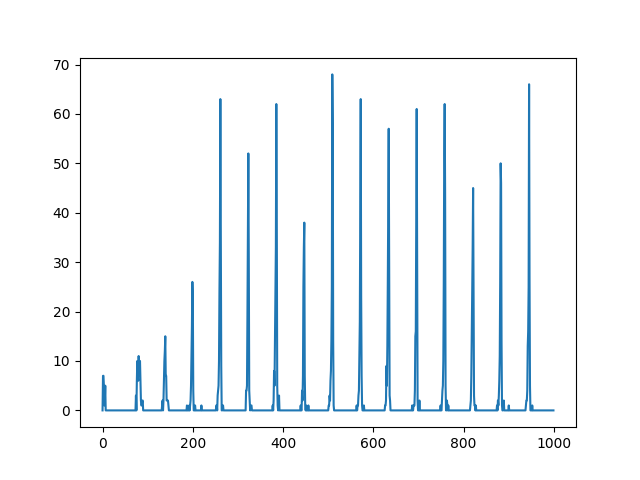

In [85]:
fig,ax = plt.subplots()
plt.plot(bin_spikes(spikes["GPeTA"]))
plt.show()

In [86]:
from scipy.signal import welch

def beta_power(sn, population):    
    spikes = sn.populations[population].get_data()['spikes']
    binned_spikes = bin_spikes(spikes)[burn_in_millis:]
    
    f, PSD = welch(binned_spikes, 
                   sampling_frequency, 
                   nperseg = (T - burn_in_millis)/2, # Takes at least 3 windows
                   noverlap= (T - burn_in_millis)/4,
                   nfft=None, 
                   scaling='density', 
                   window='hamming')
    print(f"f peak {f[np.argmax(PSD)]}")
    beta_mask = (f>12)&(f<30)
    del sn
    return np.trapz(PSD[beta_mask], x=f[beta_mask])
beta_power(sn, "GPeTA")

f peak 31.428571428571423


12.821595427739755

## Tuning
Starts an optuna study to tune `poisson_rescale` and `weight_rescale`. As objective function the total beta-range power is chosen.

In [6]:
import optuna
optuna.logging.set_verbosity(optuna.logging.INFO)

In [7]:
def build_network(poisson_rescale, rescale_weights):
    
    catalogue = NeuronCatalogue.from_yaml("tests/basal_ganglia_neurons.yaml")
    sn = SpikingNetwork.from_yaml("tests/basal_ganglia_network.yaml", catalogue)

    sn.rescale_populations(0.2)
    sn.rescale_connectivity(1)
    sn.rescale_weights(rescale_weights)
    sn.rescale_delays(1)
    
    sn.build(progress_bar=False)

    for pop in sn.populations.values():
       pop.monitorize_spikes()

    poisson_inputs = dict(STN   = [500, 0.25],
                          GPeTA = [170, 0.15],
                          GPeTI = [1530, 0.25 ],
                          FSN   = [944.4, 0.5],
                          SNR   = [600, 0.55],
                          D1    = [1120, 0.45],
                          D2    = [972.972, 0.45]
                        )
    # poisson_rescale = 0.8
    for pi in poisson_inputs.values():
        pi[1] *= poisson_rescale
        
    for pop in poisson_inputs:
        sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])
    
    return sn
    
def optimize_beta_power(trial):
    sn = build_network(trial.suggest_float("poisson_rescale", 0.1 , 2 ),
                       trial.suggest_float("weight_rescale", 0.1, 2))
    sn.run(dt=0.1, time=T)
    return beta_power(sn, "GPeTA")

In [15]:
set_verbosity(0) # Turns off C++ outputs

study_power = optuna.create_study(direction = 'maximize')
study_power.optimize(optimize_beta_power, n_trials = 2, n_jobs = 1, catch=(ValueError, TypeError))

[I 2024-01-26 02:42:29,180] A new study created in memory with name: no-name-cdbeaf36-df63-436b-ad54-403e6e8753c8
[I 2024-01-26 02:42:33,413] Trial 0 finished with value: 0.020573004289422638 and parameters: {'poisson_rescale': 1.4056065748584083, 'weight_rescale': 0.47275977775856126}. Best is trial 0 with value: 0.020573004289422638.
[I 2024-01-26 02:42:37,343] Trial 1 finished with value: 0.011178771862366993 and parameters: {'poisson_rescale': 0.4838966797840897, 'weight_rescale': 1.6171989596507512}. Best is trial 0 with value: 0.020573004289422638.
[I 2024-01-26 02:42:41,624] Trial 2 finished with value: 0.004392358137049284 and parameters: {'poisson_rescale': 0.48329773986468705, 'weight_rescale': 1.2709880354416085}. Best is trial 0 with value: 0.020573004289422638.
[I 2024-01-26 02:42:45,715] Trial 3 finished with value: 0.022424275279117153 and parameters: {'poisson_rescale': 1.8098018738606827, 'weight_rescale': 0.584979495079784}. Best is trial 3 with value: 0.0224242752791

KeyboardInterrupt: 

In [ ]:
x = []
y = []
z = []
for trial in study_power.trials:
    x += [trial.params['poisson_rescale']]
    y += [trial.params['weight_rescale']]
    z += [trial.value]

fig, ax = plt.subplots()
plt.scatter(x, y, c=z)
plt.colorbar()
plt.scatter(study_power.best_params['poisson_rescale'],study_power.best_params['weight_rescale'], marker="x", color="r")
plt.xlabel("Poisson weight global factor [a.u.]")
plt.ylabel("Internal weight global factor [a.u.]")
plt.title("Integrated beta power")

plt.show()

## Plot best params

In [ ]:
set_verbosity(1)
best_params = study_power.best_params

print(best_params)
print(study_power.best_value)

sn = build_network(best_params['poisson_rescale'], best_params['weight_rescale'])
sn.run(dt=0.1, time=8000)

In [ ]:
from scipy.integrate import simpson

timesteps_per_bin = 10
sampling_frequency = 1e4/timesteps_per_bin
fig, ax = plt.subplots()

binned_spikes = dict()
for pop in sn.populations:
    spikes = sn.populations[pop].get_data()['spikes']
    binned_spikes[pop] = bin_spikes(spikes)
    binned_spikes[pop] = binned_spikes[pop][200:]
    print(f"Mean fire rate {pop} is {np.mean(binned_spikes[pop]) :.1f} Hz")
    f, PSD = welch(binned_spikes[pop], 
                   1000, 
                   nperseg=2000, 
                   noverlap=500,
                   nfft=None, 
                   scaling='density', 
                   window='hamming')

    norm = simpson(PSD, x=f)
    plt.plot(f, PSD/norm, label=pop)
print(f"F resolution { f[1] - f[0] :.2f} Hz")
# plt.yscale('log')
plt.legend()
plt.ylabel("normalized PSD")
plt.xlabel("Frequency [Hz]")
plt.xlim(0,150)

In [ ]:
fig,ax = plt.subplots()
for pop in sn.populations:
    plt.plot(binned_spikes[pop]/sn.populations[pop].n_neurons, label=pop)
plt.axhline()
plt.xlabel("Time [ms]")
plt.ylabel("Spiking events per ms per neuron")
plt.xlim(500, 800)
plt.legend();

## Time signal analysis

NameError: name 'binned_spikes' is not defined

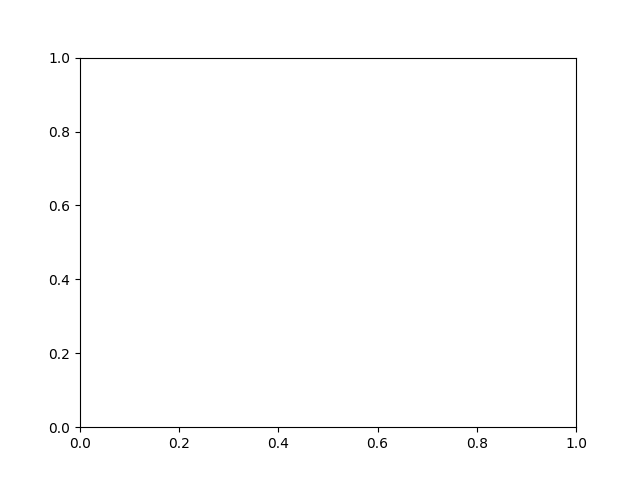

In [8]:
from scipy.signal import butter, sosfiltfilt, freqz


def bandpass(data, edges, sample_rate, poles = 5):
    sos = butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = sosfiltfilt(sos, data)
    return filtered_data
    
fig, ax = plt.subplots()

pop = "GPeTI"

tt = np.linspace(0, 5, len(binned_spikes[pop]))

plt.plot(tt,binned_spikes[pop])
plt.plot(tt, bandpass(binned_spikes[pop], [12, 24], 1000), label="beta")
plt.plot(tt, bandpass(binned_spikes[pop], [30, 140], 1000), label="gamma")
plt.xlim(1.50, 1.80)
plt.legend()

## Spectral entropy

In [9]:
from scipy.stats import entropy

def build_network(D1_freq = 1120, D2_freq = 972.972):
    catalogue = NeuronCatalogue.from_yaml("tests/basal_ganglia_neurons.yaml")
    sn = SpikingNetwork.from_yaml("tests/basal_ganglia_network.yaml", catalogue)

    sn.rescale_populations(0.2)
    sn.rescale_connectivity(1)
    sn.rescale_weights(1.17)
    sn.rescale_delays(1)
    
    sn.build(progress_bar=False)

    for pop in sn.populations.values():
       pop.monitorize_spikes()

    poisson_inputs = dict(STN   = [500, 0.25],
                          GPeTA = [170, 0.15],
                          GPeTI = [1530, 0.25 ],
                          FSN   = [944.4, 0.5],
                          SNR   = [600, 0.55],
                          D1    = [D1_freq, 0.45],
                          D2    = [D2_freq, 0.45]
                        )
    
    poisson_rescale = 1.85
    for pi in poisson_inputs.values():
        pi[1] *= poisson_rescale
        
    for pop in poisson_inputs:
        sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])
    return sn

def spectral_entropy(sn, population):    
    spikes = sn.populations[population].get_data()['spikes']
    binned_spikes = bin_spikes(spikes)[burn_in_millis:]
    
    f, PSD = welch(binned_spikes, 
                   sampling_frequency, 
                   nperseg = (T - burn_in_millis)/2, # Takes at least 3 windows
                   noverlap= (T - burn_in_millis)/4,
                   nfft=None, 
                   scaling='density', 
                   window='hamming')
    
    psd_normalized = PSD / np.trapz(PSD, x=f)
    spectral_entropy_value = entropy(psd_normalized, base=2)

    return spectral_entropy_value

def optimize_spectral_entropy(trial):
    sn = build_network(trial.suggest_float("D1_freq", 800 , 1200 ),
                       trial.suggest_float("D2_freq", 800, 1200))    
    sn.run(dt=0.1, time=T)
    return spectral_entropy(sn, "D1")

In [ ]:
set_verbosity(0) 

study_entropy = optuna.create_study(direction = 'minimize')
study_entropy.optimize(optimize_spectral_entropy, n_trials = 100, n_jobs = 1, catch=(ValueError, TypeError))

In [ ]:
x = []
y = []
z = []
for trial in study_entropy.trials:
    x += [trial.params['D1_freq']]
    y += [trial.params['D2_freq']]
    z += [trial.value]

fig, ax = plt.subplots()

plt.scatter(x, y, c=z)
plt.colorbar()
plt.scatter(study_entropy.best_params['D1_freq'],study_entropy.best_params['D2_freq'], marker="x", color="r")

plt.xlabel("D1 poisson rate [Hz]")
plt.ylabel("D2 poisson rate [Hz]")
plt.title("Spectral entropy of D1")
plt.show()

In [ ]:
set_verbosity(1)
best_params = study_entropy.best_params

print(best_params)
print(study_entropy.best_value)

# sn = build_network(**best_params)
sn = build_network(D1_freq=best_params['D1_freq'], D2_freq=best_params['D2_freq'])
sn.run(dt=0.1, time=1000)

In [ ]:
fig, ax = plt.subplots()

pop = "D1"
binned_spikes[pop] = bin_spikes(sn.populations[pop].get_data()['spikes'])
tt = np.linspace(0, 5, len(binned_spikes[pop]))
plt.plot(tt, binned_spikes[pop])
plt.plot(tt, bandpass(binned_spikes[pop], [12, 24], 1000), label="beta")
plt.plot(tt, bandpass(binned_spikes[pop], [30, 140], 1000), label="gamma")
plt.xlim(0, 5)
plt.legend()

## More parameters

In [10]:
from scipy.stats import entropy

def build_network(D1_freq = 1120, D2_freq = 972.972, D1_weight=0.45, D2_weight=0.45, 
                    FSNtoD1_w=6.6, FSNtoD2_w=4.8, 
                    weight_delta=0, delay_delta=0.0):
    
    catalogue = NeuronCatalogue.from_yaml("tests/basal_ganglia_neurons.yaml")
    sn = SpikingNetwork.from_yaml("tests/basal_ganglia_network.yaml", catalogue)

    # sn.rescale_populations(0.1)
    # sn.rescale_connectivity(1)
    sn.rescale_weights(1.17)
    # sn.rescale_delays(1)
    for projection in sn.features_dict['projections']:
        projection['features']['weight_delta'] = weight_delta
        # projection['features']['delay_delta'] = delay_delta
        if projection['name'] == "FSN->D1":
            projection['features']['weight'] = FSNtoD1_w
        if projection['name'] == "FSN->D2":
            projection['features']['weight'] = FSNtoD2_w
        
    sn.build(progress_bar=False)

    for pop in sn.populations.values():
       pop.monitorize_spikes()

    poisson_inputs = dict(STN   = [500, 0.25],
                          GPeTA = [170, 0.15],
                          GPeTI = [1530, 0.25 ],
                          FSN   = [944.4, 0.5],
                          SNR   = [600, 0.55],
                          D1    = [D1_freq, D1_weight],
                          D2    = [D2_freq, D2_weight]
                        )
    
    poisson_rescale = 1.85
    for pi in poisson_inputs.values():
        pi[1] *= poisson_rescale
        
    for pop in poisson_inputs:
        sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])
    return sn

def optimize_spectral_entropy_2(trial):

    params_intervals = dict(D1_freq = [1000,1300], D2_freq = [800, 1100], D1_weight=[0.35, 0.55], D2_weight=[0.35, 0.55], 
                    FSNtoD1_w=[5.6, 7.6], FSNtoD2_w=[3.8, 5.8], 
                    weight_delta=[0, 1], delay_delta=[0,0.5])
    
    params_suggestions = dict()
    for param_name in params_intervals.keys():
        params_suggestions[param_name] = trial.suggest_float(param_name, *(params_intervals[param_name]))
    # params_default = dict(D1_freq = 1120, D2_freq = 972.972, D1_weight=0.45, D2_weight=0.45, 
    #                 FSNtoD1_w=6.6, FSNtoD2_w=4.8, 
    #                 weight_delta=0, delay_delta=0.0)
    sn = build_network(**params_suggestions)    
    sn.run(dt=0.1, time=T)
    return spectral_entropy(sn, "D1")

In [11]:
set_verbosity(0) 

study_entropy2 = optuna.create_study(direction = 'minimize', study_name="entropy2")
study_entropy2.optimize(optimize_spectral_entropy_2, n_trials = 250, n_jobs = 3, catch=(RuntimeError))

[I 2024-01-26 03:02:02,014] A new study created in memory with name: entropy2
[I 2024-01-26 03:02:39,284] Trial 0 finished with value: 6.264471529583149 and parameters: {'D1_freq': 1109.7352651215829, 'D2_freq': 1082.1319293725908, 'D1_weight': 0.39674653858427394, 'D2_weight': 0.4942301091452179, 'FSNtoD1_w': 7.361288473373077, 'FSNtoD2_w': 5.566143322029461, 'weight_delta': 0.3226802394965127, 'delay_delta': 0.1769478851935944}. Best is trial 0 with value: 6.264471529583149.
[I 2024-01-26 03:02:51,264] Trial 1 finished with value: 5.689438106965478 and parameters: {'D1_freq': 1260.54477364394, 'D2_freq': 962.6154372576973, 'D1_weight': 0.4592878112481304, 'D2_weight': 0.5258657745508886, 'FSNtoD1_w': 7.125110004213671, 'FSNtoD2_w': 3.8194018019182527, 'weight_delta': 0.2091174408385349, 'delay_delta': 0.40647733724473445}. Best is trial 1 with value: 5.689438106965478.
IOStream.flush timed out
[I 2024-01-26 03:02:51,277] Trial 2 finished with value: 5.168607722468785 and parameters: 

In [12]:
# results_df = study_entropy2.trials_dataframe()
# results_df.to_csv('entropy2.csv', index=False)

In [68]:
set_verbosity(1)
best_params = study_entropy2.best_params

print(best_params)
print(study_entropy2.best_value)

sn = build_network(**best_params)

sn.run(dt=0.1, time=8000)

{'D1_freq': 1282.987406679966, 'D2_freq': 1070.480828079436, 'D1_weight': 0.5499335915656983, 'D2_weight': 0.48215306371274885, 'FSNtoD1_w': 5.717419063813024, 'FSNtoD2_w': 5.605281476461306, 'weight_delta': 0.49456295842491427, 'delay_delta': 0.23078390797861803}
2.354851382969862
Running network consisting of 14622 neurons for 80000 timesteps
--------------------------------------------------
**************************************************
Simulation took 148 s	(1.85834 ms/step)
	Gathering time avg: 0.103212 us/step
	Inject time avg: 171.702 us/step
Population evolution stats:
	0:
		evolution:	473.606 us/step	---	78 ns/step/neuron
		spike emission:	68.6655 us/step	---	11 ns/step/neuron
	1:
		evolution:	467.965 us/step	---	77 ns/step/neuron
		spike emission:	124.665 us/step	---	20 ns/step/neuron
	2:
		evolution:	92.3875 us/step	---	219 ns/step/neuron
		spike emission:	33.0649 us/step	---	78 ns/step/neuron
	3:
		evolution:	115.962 us/step	---	148 ns/step/neuron
		spike emission:	28.

Text(0.5, 0, 'time [s]')

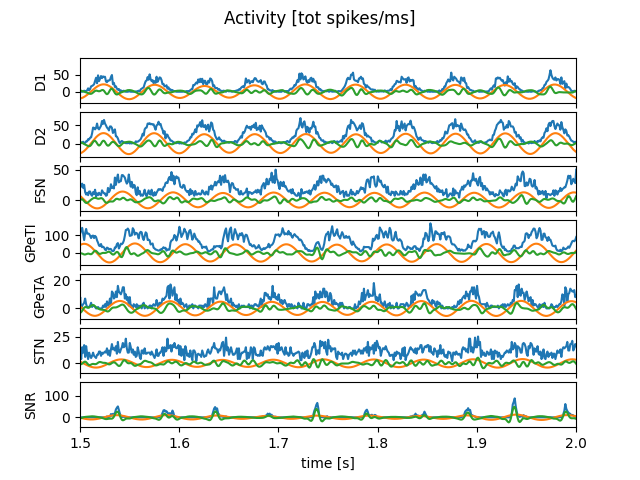

In [79]:
fig, axes = plt.subplots(len(sn.populations), 1, sharex=True)
binned_spikes= dict()
pop = "D1"
for ax, pop in zip(axes, sn.populations):
    binned_spikes[pop] = bin_spikes(sn.populations[pop].get_data()['spikes'])
    tt = np.linspace(0, 8, len(binned_spikes[pop]))
    ax.plot(tt, binned_spikes[pop])
    ax.plot(tt, bandpass(binned_spikes[pop], [12, 24], 1000), label="beta")
    ax.plot(tt, bandpass(binned_spikes[pop], [30, 140], 1000), label="gamma")
    ax.set_ylabel(pop)
ax.set_xlim(1.5, 2)
fig.suptitle("Activity [tot spikes/ms]")
ax.set_xlabel("time [s]")
# fig.legend()

Mean fire rate D1 is 16.2 Hz
Mean fire rate D2 is 24.2 Hz
Mean fire rate FSN is 20.2 Hz
Mean fire rate GPeTI is 68.0 Hz
Mean fire rate GPeTA is 4.8 Hz
Mean fire rate STN is 11.3 Hz
Mean fire rate SNR is 5.2 Hz
df = 0.5


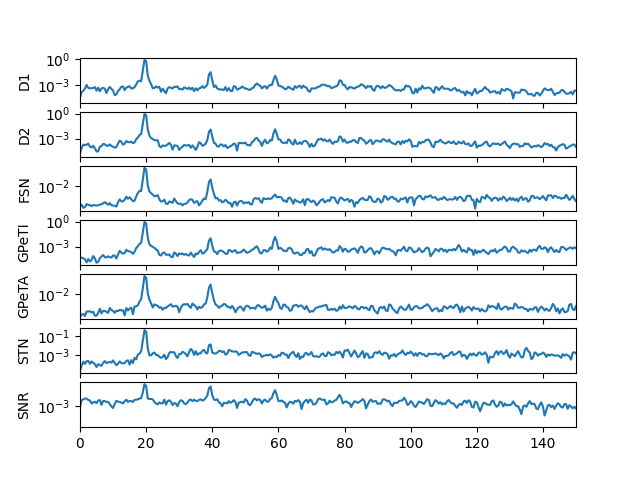

In [81]:
from scipy.integrate import simpson

fig, axes =plt.subplots(len(sn.populations), 1, sharex=True)
for ax, pop in zip(axes, sn.populations):
    spikes = sn.populations[pop].get_data()['spikes']
    binned_spikes[pop] = bin_spikes(spikes)
    # print(len(binned_spikes[pop]))
    binned_spikes[pop] = binned_spikes[pop][200:]
    print(f"Mean fire rate {pop} is {np.mean(binned_spikes[pop]) :.1f} Hz")
    f, PSD = welch(binned_spikes[pop], 
                   1000, 
                   nperseg=2000, 
                   noverlap=400,
                   nfft=None, 
                   scaling='density', 
                   window='hamming')

    norm = simpson(PSD, x=f)
    ax.plot(f, PSD/norm, label=pop)
    ax.set_yscale('log')
    ax.set_ylabel(pop)
print(f"df = {f[1] -f[0]}")
# plt.legend()
plt.xlim(0,150)
plt.show()